In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

In [2]:

_REP_PATH_ = os.getcwd()


In [3]:
train_df = pd.read_csv(_REP_PATH_+'/data/train_nettoye.csv', index_col=0)
test_df = pd.read_csv(_REP_PATH_+'/data/test_nettoye.csv', index_col=0)

On s' apprête à entrainer notre modèle XGBoost. y_train, la colonne `tip\_amount`, sera la $\textit{target variable}$

In [4]:
y_train=train_df['tip_amount']

train_df.drop(columns=['tip_amount'],inplace=True)


In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import plot_importance

In [6]:
#Instancier un XGBRegressor

xgb_model = xgb.XGBRegressor(objective='reg:squarederror',random_state=10)

In [7]:
#Séléctions des hyperparamètres

params_random_xgb = {
    'learning_rate': np.arange(0.01, 0.15, 0.01), 
    'n_estimators': [200,300,400],
    'max_depth': range(2, 12, 2)
}



randomized_xgb = RandomizedSearchCV(param_distributions=params_random_xgb, estimator=xgb_model,
                                    scoring="r2", n_iter=60, cv=5,n_jobs=-1)


A la suite de notre cette phase de recherche `RandomizedSearcCV` codé ainsi, on a obtenu le modèle best_xgb_model dont on présente afin d'éviter de relancer la phase de recherche du meilleur estimateur coûteuse en temps.

```
randomized_xgb.fit(train_df, y_train)

best_xgb_model = randomized_xgb.best_estimator_

```

In [9]:
#Reinstancier le modèle sans lancer le RandomizedSearchCV dont le meilleur estimateur est

best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
             base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None,  monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=10)



In [10]:
best_xgb_model.fit(train_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [11]:
#Prédiction par le XGBRegressor

y_pred = best_xgb_model.predict(test_df)
y_pred = np.maximum(y_pred, 0)  # Assure que toutes les valeurs sont positives car c'est une régression

In [12]:
prediction = pd.DataFrame(np.arange(len(y_pred), dtype = int).T, columns  = ["row_ID"])
prediction["tip_amount"] = y_pred
prediction.to_parquet(_REP_PATH_+ "/output/prediction_fct_xgb_positive.parquet")

In [13]:

import shap

explainer = shap.Explainer(best_xgb_model)





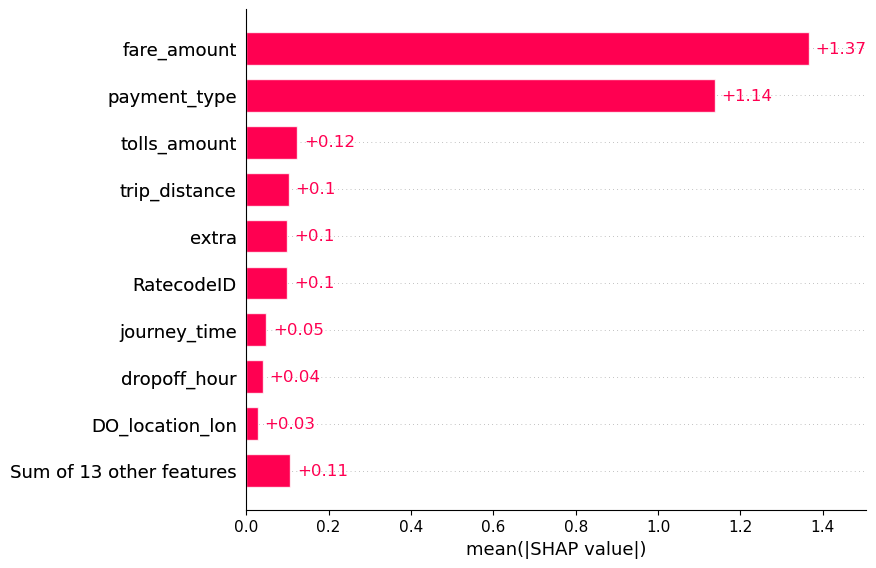

In [14]:

shap_values = explainer(test_df)


shap.plots.bar(shap_values)




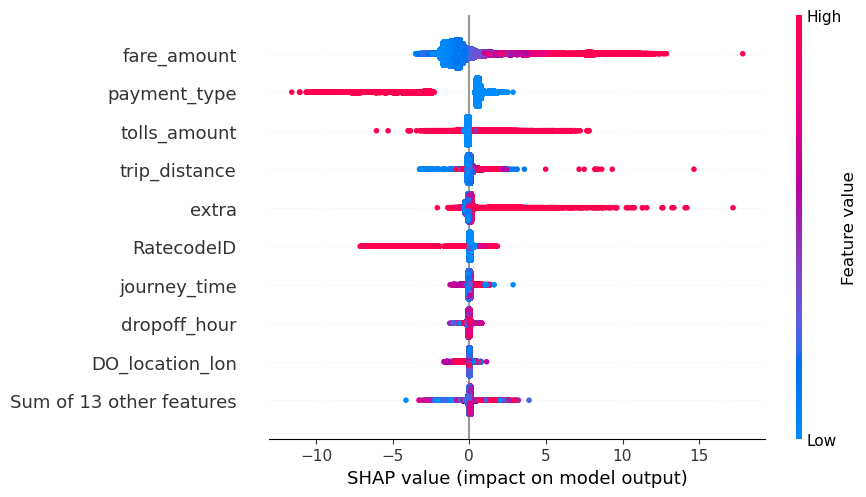

In [15]:


shap.plots.beeswarm(shap_values)


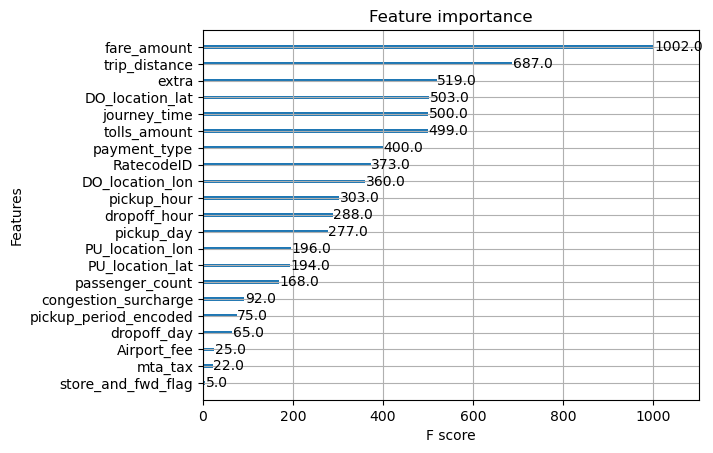

In [16]:
#La feature importance du XGBoost selon le F score





plot_importance(best_xgb_model)
plt.show()
